In [41]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectPercentile, f_classif, chi2, VarianceThreshold, SelectKBest, mutual_info_classif, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix as cm
from sklearn import model_selection
from sklearn import neighbors
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scikitplot as skplt

In [ ]:
# Import de la table des SARL - Unité légale
data = pd.read_csv('C:/Users/Square 769/Documents/SIRENE/072019/BASE_FINALE_010819.csv', encoding = 'utf-8')

In [ ]:
# On extrait un échantillon de la table complète pour limiter le temps d'apprentissage
# On stock Sample pour faciliter les futurs imports
df_sample = data.sample(frac = 0.05)
df_sample.to_csv('C:/Users/Square 769/Documents/SIRENE/072019/SARL_SAMPLE.csv', encoding = 'utf-8', index = False)

In [2]:
# Import de SARL_SAMPLE
data = pd.read_csv('C:/Users/Square 769/Documents/SIRENE/072019/SARL_SAMPLE.csv', encoding = 'utf-8')

In [ ]:
data.info()

In [ ]:
# Analyse et Exploration de données avec Pandas profiling
import pandas_profiling
profile = data.profile_report(title = 'Pandas Profiling Report')
profile.to_file(output_file = "Profiling_Cessation_SARL.html")

In [3]:
# Variables exclues short-list variables financières
short_list = ['etatAdministratifUniteLegale','N0_AF', 'N0_BE', 'N0_BV', 'N0_DE', 'N0_IR', 
              'N0_PT', 'VarN0_AF', 'VarN0_BV', 'VarN0_CP', 'VarN0_TM', 
              'VarN0_RN', 'VarN0_RB', 'VAR_DEFAILLANCE', 'nb_etablissement_ferme', 
              'anc_der_chg_cat_ju', 'anc_der_chg_act', 'anc_der_chg_den', 'anc_der_chg_emp', 'age_unite_legale']
data = data[short_list]

In [4]:
data_flow = data.join(pd.get_dummies(data.etatAdministratifUniteLegale, prefix = "CESSATION"))
data_flow.drop(['CESSATION_A','etatAdministratifUniteLegale'], axis = 1, inplace = True)
data_flow.fillna(99, inplace = True)
target = data_flow['CESSATION_C']
feature = data_flow.drop('CESSATION_C', axis = 1)

In [ ]:
# Représentation graphique - Analyse de densité
full = data_flow.drop('CESSATION_C', axis = 1)
liste_totale = full.columns.tolist()

# Split CESSATION / ACTIF
data_flow_0 = data_flow[data_flow['CESSATION_C'] == 0]
data_flow_1 = data_flow[data_flow['CESSATION_C'] == 1]

# Analyse des courbes de densité CESSATION / ACTIF
j = 1
fig = plt.figure(figsize=(20,130))
for i in liste_totale:
    ax = fig.add_subplot(20, 3, j)
    plt.title("Kde plot for : " + i + "\n(Actif/Cessation)")
    sns.kdeplot(data_flow_0[i], shade=True, cut = 0, color = 'blue', ax = ax, legend = False) 
    ax2 = ax.twinx()
    sns.kdeplot(data_flow_1[i], shade=True, cut = 0, color = 'red', ax = ax2, legend = False)
    j = j + 1

In [6]:
# Module de sélection des caractéristiques principales du modèle
# Sélection via corrélation de Pearson - Test
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # Calcul de la corrélation de Pearson entre chaque Feature et la target
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

cor_support, cor_feature = cor_selector(feature, target, 10)
print(str(len(cor_feature)), 'selected features')

from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

def selector_mult(X,y,num_feats):
    
    #Embeded method - Select from model Random Forest Classifier
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, y)
    embeded_rf_support = embeded_rf_selector.get_support()
    
    #Select KBest - ChisSquare Maximizer
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, y)
    chi_support = chi_selector.get_support()
    
    #Recursive Feature ELimination
    from sklearn.preprocessing import KBinsDiscretizer
    rfe_selector = RFE(estimator=LogisticRegression(C = 1.0, max_iter = 100), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, y)
    rfe_support = rfe_selector.get_support()
    
    #KBest from ANOVA
    f_classif_selector = SelectKBest(f_classif, k=num_feats)
    f_classif_selector.fit(X, y)
    f_support = f_classif_selector.get_support()
    
    #KBest from Mutual Info
    mic = SelectKBest(score_func = mutual_info_classif, k = num_feats)
    mic.fit(X, y)
    mic_support = mic.get_support()
    
    return f_support, rfe_support, chi_support, embeded_rf_support, mic_support
    
f_support, rfe_support, chi_support, embeded_rf_support, mic_support = selector_mult(feature, target, 10)

# Création du DataFrame - Rapport de sélection
feature_name = feature.columns.tolist()
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'F Classification': f_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Random Forest':embeded_rf_support, 'Mutual Info':mic_support})

# Dénombrement des features sélectionnés
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)

# Indicateur features sélectionnés triés par ordre décroissant
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

return feature_selection_df

10 selected features
Fitting estimator with 19 features.


C:\Users\Square 769\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Feature,Pearson,F Classification,Chi-2,RFE,Random Forest,Mutual Info,Total
1,VarN0_RN,True,True,True,True,True,True,6
2,N0_IR,True,True,True,True,True,True,6
3,VarN0_TM,True,True,True,False,True,True,5
4,VarN0_RB,True,True,True,True,True,False,5
5,VarN0_BV,True,True,False,True,True,True,5
6,N0_BE,True,True,True,True,True,False,5
7,N0_PT,False,False,True,True,True,True,4
8,nb_etablissement_ferme,True,True,False,True,False,False,3
9,anc_der_chg_den,True,True,True,False,False,False,3
10,anc_der_chg_cat_ju,True,True,True,False,False,False,3


In [12]:
# On retient arbitrairement les features sélectionnés par au moins 3 procédures de sélection
feature_model = feature_selection_df[feature_selection_df['Total'] >= 3]
liste_selected = []
for i in feature_model.Feature:
    liste_selected.append(i)

In [13]:
target = data_flow['CESSATION_C']
feature = data_flow[liste_selected]

In [14]:
# On force les valeurs manquantes à la moyenne des features
feature.fillna(feature.mean(), inplace = True)
corr = feature.corr()

In [15]:
# Visualisation
corr

,VarN0_RN,N0_IR,VarN0_TM,VarN0_RB,VarN0_BV,N0_BE,N0_PT,nb_etablissement_ferme,anc_der_chg_den,anc_der_chg_cat_ju,age_unite_legale
VarN0_RN,1.000000,-0.277048,0.629150,0.822073,-0.086754,0.066399,-0.342384,-0.122391,0.063114,0.060193,-0.036680
N0_IR,-0.277048,1.000000,-0.297212,-0.386570,0.032123,0.356049,0.469723,0.050045,0.008593,-0.001935,-0.038314
VarN0_TM,0.629150,-0.297212,1.000000,0.385014,-0.142041,-0.155860,-0.265773,-0.082102,-0.023229,-0.022923,0.048229
VarN0_RB,0.822073,-0.386570,0.385014,1.000000,0.108734,0.103354,-0.120631,-0.082749,0.074810,0.073858,-0.042593
VarN0_BV,-0.086754,0.032123,-0.142041,0.108734,1.000000,-0.116923,0.069379,0.046701,-0.072456,-0.082340,0.072029
N0_BE,0.066399,0.356049,-0.155860,0.103354,-0.116923,1.000000,0.273602,-0.012207,0.117583,0.123394,-0.140585
N0_PT,-0.342384,0.469723,-0.265773,-0.120631,0.069379,0.273602,1.000000,0.023072,-0.009071,-0.016970,0.073122
nb_etablissement_ferme,-0.122391,0.050045,-0.082102,-0.082749,0.046701,-0.012207,0.023072,1.000000,-0.103625,-0.091754,0.212927
anc_der_chg_den,0.063114,0.008593,-0.023229,0.074810,-0.072456,0.117583,-0.009071,-0.103625,1.000000,0.557096,-0.332662
anc_der_chg_cat_ju,0.060193,-0.001935,-0.022923,0.073858,-0.082340,0.123394,-0.016970,-0.091754,0.557096,1.000000,-0.354742


In [16]:
# Exclusion des variables fortement corrélées >0.9
columns = np.full((corr.shape[0],), True, dtype = bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                
selected_columns = feature.columns[columns]
feature = feature[selected_columns]

print(feature.columns)

Index(['VarN0_RN', 'N0_IR', 'VarN0_TM', 'VarN0_RB', 'VarN0_BV', 'N0_BE',
       'N0_PT', 'nb_etablissement_ferme', 'anc_der_chg_den',
       'anc_der_chg_cat_ju', 'age_unite_legale'],
      dtype='object')


Machine Learning

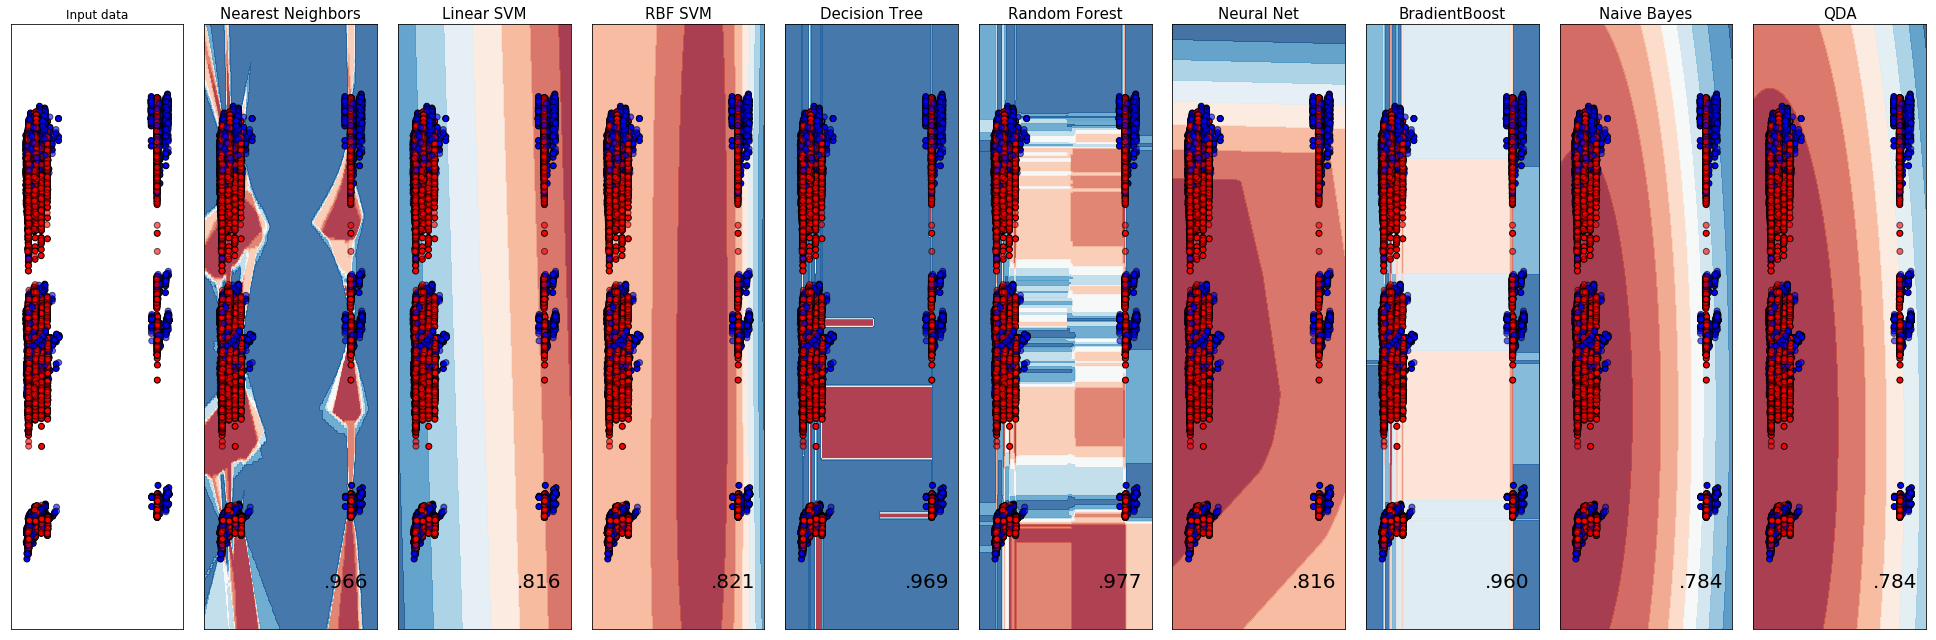

In [18]:
# Thanks to: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "BradientBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(n_neighbors = 6),
    SVC(kernel = "linear", C = 0.025),
    SVC(gamma = 0.1, C = 10, kernel = 'rbf'),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_jobs=-1),
    MLPClassifier(alpha = 1, max_iter = 1000),
    GradientBoostingClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X = data_flow.drop(['CESSATION_C'], axis = 1).values
pca = PCA(n_components=2,svd_solver='full')
X = pca.fit_transform(X)
y = data_flow['CESSATION_C']


# X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
#                            random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
#X += 2 * rng.uniform(size=X.shape)
#linearly_separable = (X, y)

datasets = [data_flow]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    #X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name, size = 15)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.3f' % score).lstrip('0'),
                size=20, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

In [28]:
# Ploting confusion matrix
from itertools import product
import itertools

def plot_confusion_matrix(cm_m, title="",
                          cmap = plt.cm.Blues):
    
    class_names = [0,1]
    plt.figure(figsize = (8,6))
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(cm_m), annot = True, cmap = cmap, fmt = 'g')
    plt.title('Confusion matrix '+title, y = 1.1)
    plt.ylabel('Current label')
    plt.xlabel('Predicted label')
    plt.figure()

Random Forest Classifier

In [48]:
# Search Grid - Random Forest
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.3, random_state = 123)

clfrf = ensemble.RandomForestClassifier(n_jobs = -1, random_state = 321)

parametres = {"n_jobs" : [-1], "random_state" : [123], "max_features":['sqrt', 'log2', None], 
              "min_samples_split":[2], "n_estimators":np.arange(2,11,1), "max_depth":np.arange(2,11,1)}

# "min_samples_split":np.arange(2,11,1)

grid_clf = model_selection.GridSearchCV(estimator = clfrf, param_grid = parametres)

grille = grid_clf.fit(X_train, y_train)
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,["params","mean_test_score"]])
print(grid_clf.best_params_)

#{'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 6, 'n_jobs': -1, 'random_state': 123}

                                                params  mean_test_score
0    {'max_depth': 2, 'max_features': 'sqrt', 'min_...         0.911884
1    {'max_depth': 2, 'max_features': 'sqrt', 'min_...         0.903694
2    {'max_depth': 2, 'max_features': 'sqrt', 'min_...         0.915483
3    {'max_depth': 2, 'max_features': 'sqrt', 'min_...         0.918764
4    {'max_depth': 2, 'max_features': 'sqrt', 'min_...         0.919718
5    {'max_depth': 2, 'max_features': 'sqrt', 'min_...         0.919387
6    {'max_depth': 2, 'max_features': 'sqrt', 'min_...         0.917772
7    {'max_depth': 2, 'max_features': 'sqrt', 'min_...         0.920023
8    {'max_depth': 2, 'max_features': 'sqrt', 'min_...         0.922274
9    {'max_depth': 2, 'max_features': 'log2', 'min_...         0.911884
10   {'max_depth': 2, 'max_features': 'log2', 'min_...         0.903694
11   {'max_depth': 2, 'max_features': 'log2', 'min_...         0.915483
12   {'max_depth': 2, 'max_features': 'log2', 'min_...         0

In [90]:
# Utilisation d'une random forest
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.3, random_state = 123)

{'max_depth': 9, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 8, 'n_jobs': -1, 'random_state': 123}

clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state = 123, 
                                      max_features = 'sqrt', min_samples_split = 2, 
                                      max_depth = 9, n_estimators = 8)
clf.fit(X_train, y_train)

feature_name = X_train.columns.tolist()
feature_importance = clf.feature_importances_.tolist()
feature_importance_df = pd.DataFrame({'Feature':feature_name, 'Importance':feature_importance})
feature_importance_df = feature_importance_df.sort_values(['Importance','Feature'] , ascending=False)

feature_importance_df

,Feature,Importance
1,N0_IR,0.257447
3,VarN0_RB,0.156456
2,VarN0_TM,0.137587
4,VarN0_BV,0.122485
6,N0_PT,0.119610
0,VarN0_RN,0.091318
5,N0_BE,0.083627
7,nb_etablissement_ferme,0.023751
10,age_unite_legale,0.007349
8,anc_der_chg_den,0.000209


In [91]:
print("Score on test Sample : %0.4f" % f1_score(y_test, clf.predict(X_test)))
print("  ")
print(classification_report(y_test, clf.predict(X_test)))

Score on test Sample : 0.9586
  
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     27422
           1       1.00      0.92      0.96      6279

    accuracy                           0.99     33701
   macro avg       0.99      0.96      0.97     33701
weighted avg       0.99      0.99      0.98     33701



<Figure size 576x432 with 0 Axes>

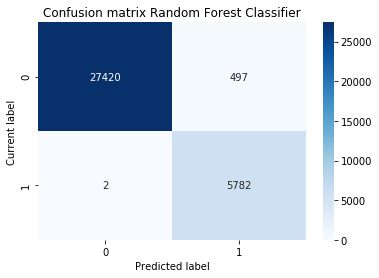

<Figure size 432x288 with 0 Axes>

In [92]:
cm_plot = cm(clf.predict(X_test), y_test)
plot_confusion_matrix(cm_plot, title = 'Random Forest Classifier')

C:\Users\Square 769\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


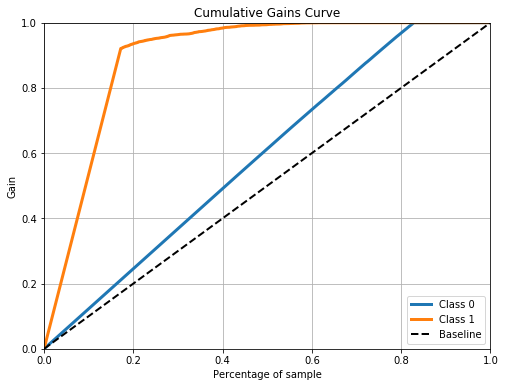

In [93]:
# Cumulative Gain Curve
y_probas = clf.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize = (8,6))
plt.show()

K Nearest Neighbors

In [ ]:
# Grid Search
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.3, random_state = 123)

knn = neighbors.KNeighborsClassifier(n_neighbors = 2)
parametres = {"algorithm": ['auto','ball_tree','kd_tree','brute'], "metric":['minkowski','manhattan','chebyshev']}
grid_knn = GridSearchCV(estimator = knn, param_grid = parametres)
grille = grid_knn.fit(X_train, y_train)

print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,["params","mean_test_score"]])
print(grid_knn.best_params_)

In [94]:
# Classification par les KNearestNeighbor
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.3, random_state = 123)

#{'algorithm': 'brute', 'metric': 'chebyshev'}

knn = neighbors.KNeighborsClassifier(n_neighbors = 2, algorithm = 'brute', metric = 'chebyshev')

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print("Score on test Sample : %0.4f" % f1_score(y_test, y_pred))
print("  ")
print(classification_report(y_test, y_pred))
print("  ")

Score on test Sample : 0.9412
  
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     27422
           1       0.99      0.89      0.94      6279

    accuracy                           0.98     33701
   macro avg       0.98      0.95      0.96     33701
weighted avg       0.98      0.98      0.98     33701

  


<Figure size 576x432 with 0 Axes>

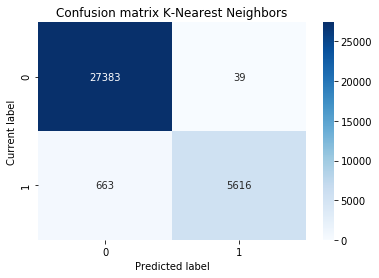

<Figure size 432x288 with 0 Axes>

In [55]:
cm_plot = cm(y_test, y_pred)
plot_confusion_matrix(cm_plot, title = 'K-Nearest Neighbors')

Decision Tree Classifier

In [23]:
# Grid search - Decision Tree
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.3, random_state = 123)

clf = DecisionTreeClassifier(criterion = "gini", max_depth = 2, random_state = 123, min_impurity_decrease = 1e-3)

parametres = {"random_state" : [123], 
              "criterion":['gini', 'entropy'], 
              "max_depth":np.arange(2,11,1), 
              "max_features":['sqrt', 'log2', None], 
              "min_samples_split":np.arange(2,10,1)}

grid_clf = model_selection.GridSearchCV(estimator = clf, param_grid = parametres)
grille = grid_clf.fit(X_train, y_train)

print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,["params","mean_test_score"]])
print(grid_clf.best_params_)

                                                params  mean_test_score
0    {'criterion': 'gini', 'max_depth': 2, 'max_fea...         0.885903
1    {'criterion': 'gini', 'max_depth': 2, 'max_fea...         0.885903
2    {'criterion': 'gini', 'max_depth': 2, 'max_fea...         0.885903
3    {'criterion': 'gini', 'max_depth': 2, 'max_fea...         0.885903
4    {'criterion': 'gini', 'max_depth': 2, 'max_fea...         0.885903
5    {'criterion': 'gini', 'max_depth': 2, 'max_fea...         0.885903
6    {'criterion': 'gini', 'max_depth': 2, 'max_fea...         0.885903
7    {'criterion': 'gini', 'max_depth': 2, 'max_fea...         0.885903
8    {'criterion': 'gini', 'max_depth': 2, 'max_fea...         0.885903
9    {'criterion': 'gini', 'max_depth': 2, 'max_fea...         0.885903
10   {'criterion': 'gini', 'max_depth': 2, 'max_fea...         0.885903
11   {'criterion': 'gini', 'max_depth': 2, 'max_fea...         0.885903
12   {'criterion': 'gini', 'max_depth': 2, 'max_fea...         0

In [84]:
# Classification par arbre de décision
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.3, random_state = 123)

dt_clf = DecisionTreeClassifier(criterion = "entropy", max_depth = 7, max_features = 'sqrt', 
                                min_samples_split = 2, random_state = 123, min_impurity_decrease = 1e-3)

dt_clf.fit(X_train, y_train)

#{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 2, 'random_state': 123}

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=7, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.001, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [85]:
y_pred = dt_clf.predict(X_test)
print("Score on test Sample : %0.4f" % f1_score(y_test, y_pred))
print("  ")
print(classification_report(y_test, y_pred))
print("  ")

Score on test Sample : 0.9582
  
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     27422
           1       1.00      0.92      0.96      6279

    accuracy                           0.99     33701
   macro avg       0.99      0.96      0.97     33701
weighted avg       0.99      0.99      0.98     33701

  


<Figure size 576x432 with 0 Axes>

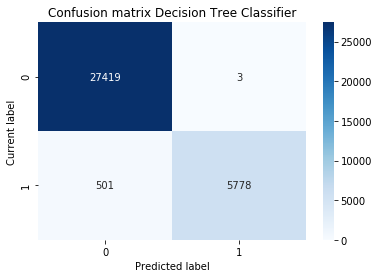

<Figure size 432x288 with 0 Axes>

In [86]:
cm_plot = cm(y_test, y_pred)
plot_confusion_matrix(cm_plot, title = 'Decision Tree Classifier')

In [87]:
from IPython.display import Image  
from sklearn import tree
from sklearn.externals.six import StringIO
import graphviz
import pydotplus

dot_data = StringIO()

tree.export_graphviz(dt_clf, out_file=dot_data, feature_names = X_train.columns, class_names=['0', '1'], filled=True, rounded=True, proportion=True, impurity=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

graph.write_png('decision_tree.png')

True

Gradient Boosting Tree

In [115]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, random_state = 257, test_size = 0.3)

params = {'n_estimators':5,'max_depth':8,'learning_rate':0.5,'min_samples_leaf':2,'random_state':123}
gbm = GradientBoostingClassifier(**params)

parametres = {"n_estimators":np.arange(2,11,1), 'max_depth':np.arange(2,11,1), 'learning_rate':[0.01,0.05,0.1,0.25,0.5]}
grid_gbm = GridSearchCV(estimator = gbm, param_grid = parametres)
grille = grid_gbm.fit(X_train, y_train)

print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,["params","mean_test_score"]])
print(grid_gbm.best_params_)

#'learning_rate': 0.1, 'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 5

                                                params  mean_test_score
0    {'learning_rate': 0.01, 'max_depth': 2, 'n_est...         0.815947
1    {'learning_rate': 0.01, 'max_depth': 2, 'n_est...         0.815947
2    {'learning_rate': 0.01, 'max_depth': 2, 'n_est...         0.815947
3    {'learning_rate': 0.01, 'max_depth': 2, 'n_est...         0.815947
4    {'learning_rate': 0.01, 'max_depth': 2, 'n_est...         0.815947
5    {'learning_rate': 0.01, 'max_depth': 2, 'n_est...         0.815947
6    {'learning_rate': 0.01, 'max_depth': 2, 'n_est...         0.815947
7    {'learning_rate': 0.01, 'max_depth': 2, 'n_est...         0.815947
8    {'learning_rate': 0.01, 'max_depth': 2, 'n_est...         0.815947
9    {'learning_rate': 0.01, 'max_depth': 3, 'n_est...         0.815947
10   {'learning_rate': 0.01, 'max_depth': 3, 'n_est...         0.815947
11   {'learning_rate': 0.01, 'max_depth': 3, 'n_est...         0.815947
12   {'learning_rate': 0.01, 'max_depth': 3, 'n_est...         0

In [119]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, random_state = 257, test_size = 0.3)

params = {'n_estimators':5,'max_depth':7,'learning_rate':0.5,'min_samples_leaf':2,'random_state':123}
#'learning_rate': 0.1, 'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 5

gbm = GradientBoostingClassifier(**params)
gbm.fit(X_train, y_train)

y_pred = gbm.predict(X_test)

print("Score on selected feature data : %0.4f" % f1_score(y_test, y_pred))
print("  ")
print(classification_report(y_test,y_pred))
print("  ")

Score on selected feature data : 0.9608
  
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     27301
           1       1.00      0.93      0.96      6400

    accuracy                           0.99     33701
   macro avg       0.99      0.96      0.98     33701
weighted avg       0.99      0.99      0.99     33701

  


<Figure size 576x432 with 0 Axes>

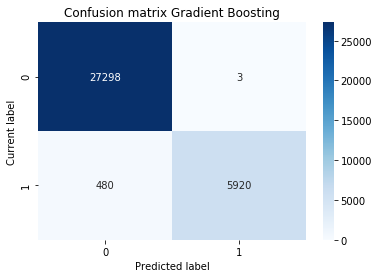

<Figure size 432x288 with 0 Axes>

In [120]:
cm_plot = cm(y_test, y_pred)
plot_confusion_matrix(cm_plot, title = 'Gradient Boosting')

Support Vector Machine

In [121]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, random_state = 123, test_size = 0.3)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

clfsvm = svm.SVC(gamma = 0.01, kernel = 'linear')
parametres = {"C":[0.1,1,10],"kernel":['rbf'],"gamma":[0.001,0.01,0.1,0.5]}
grid_clf = model_selection.GridSearchCV(estimator = clfsvm, param_grid = parametres)

grille = grid_clf.fit(X_train_scaled, y_train)

print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,["params","mean_test_score"]])

print(grid_clf.best_params_)

                                         params  mean_test_score
0   {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}         0.872118
1    {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}         0.933872
2     {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}         0.972315
3     {'C': 0.1, 'gamma': 0.5, 'kernel': 'rbf'}         0.982082
4     {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}         0.909074
5      {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}         0.959751
6       {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}         0.984765
7       {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}         0.984841
8    {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}         0.936568
9     {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}         0.983430
10     {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}         0.985655
11     {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}         0.984918
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [122]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, random_state = 123, test_size = 0.3)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

clfsvm = svm.SVC(C = 10, gamma = 0.1, kernel = 'rbf')
#{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
clfsvm.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = clfsvm.predict(X_test_scaled)

print("Score on selected feature data : %0.4f" % f1_score(y_test, y_pred))
print("  ")
print(classification_report(y_test,y_pred))
print("  ")

Score on selected feature data : 0.9575
  
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     27422
           1       1.00      0.92      0.96      6279

    accuracy                           0.98     33701
   macro avg       0.99      0.96      0.97     33701
weighted avg       0.99      0.98      0.98     33701

  


<Figure size 576x432 with 0 Axes>

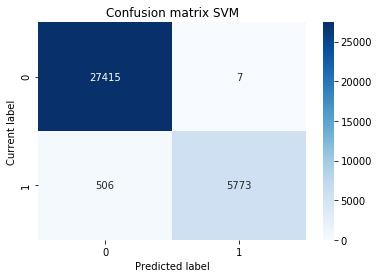

<Figure size 432x288 with 0 Axes>

In [123]:
cm_plot = cm(y_test, y_pred)
plot_confusion_matrix(cm_plot, title = 'SVM')